In [107]:
#!/usr/bin/env python

from dataclasses import astuple
from datetime import datetime
from utc_bot import UTCBot, start_bot
import proto.utc_bot as pb
import betterproto

import asyncio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import norm


**BSM Formulas**

In [9]:
# Recall BSM Formulas:

def d1(S,K,T,r,sigma):
    return(np.log(S/K)+(r+sigma**2/2.)*T)/(sigma*np.sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*np.sqrt(T)

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*np.exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
def bs_put(S,K,T,r,sigma):
    return K*np.exp(-r*T)-S+bs_call(S,K,T,r,sigma)

**Reverse BSM/ Implied Volatility**

In [10]:
# Implied Volatility:

def iv_call(S,K,T,r,C):
    return max(0, fsolve((lambda sigma: np.abs(bs_call(S,K,T,r,sigma) - C)), [1])[0])
                      
def iv_put(S,K,T,r,P):
    return max(0, fsolve((lambda sigma: np.abs(bs_put(S,K,T,r,sigma) - P)), [1])[0])

**Greeks**

In [13]:
def delta_call(S,K,T,C):
    sigma = iv_call(S,K,T,0,C)
    return 100 * norm.cdf(d1(S,K,T,0,sigma))

def gamma_call(S,K,T,C):
    sigma = iv_call(S,K,T,0,C)
    return 100 * norm.pdf(d1(S,K,T,0,sigma))/(S * sigma * np.sqrt(T))

def vega_call(S,K,T,C):
    sigma = iv_call(S,K,T,0,C)
    return 100 * norm.pdf(d1(S,K,T,0,sigma)) * S * np.sqrt(T)

def theta_call(S,K,T,C):
    sigma = iv_call(S,K,T,0,C)
    return 100 * S * norm.pdf(d1(S,K,T,0,sigma)) * sigma/(2 * np.sqrt(T))

def delta_put(S,K,T,C):
    sigma = iv_put(S,K,T,0,C)
    return 100 * (norm.cdf(d1(S,K,T,0,sigma)) - 1)

def gamma_put(S,K,T,C):
    sigma = iv_put(S,K,T,0,C)
    return 100 * norm.pdf(d1(S,K,T,0,sigma))/(S * sigma * np.sqrt(T))

def vega_put(S,K,T,C):
    sigma = iv_put(S,K,T,0,C)
    return 100 * norm.pdf(d1(S,K,T,0,sigma)) * S * np.sqrt(T)

def theta_put(S,K,T,C):
    sigma = iv_put(S,K,T,0,C)
    return 100 * S * norm.pdf(d1(S,K,T,0,sigma)) * sigma/(2 * np.sqrt(T))

# input delta, gamma, theta, and vega
# output dictionary with keys d,g,t,v and list [true if broke risk limit, how much above risk limit it is]
def check_valid_trade(self, tag,S,K,T,C):
    if tag == "C":
        d = delta_call(S,K,T,C)
        g = gamma_call(S,K,T,C)
        t = theta_call(S,K,T,C)
        v = vega_call(S,K,T,C)
    else:
        d = delta_put(S,K,T,C)
        g = gamma_put(S,K,T,C)
        t = theta_put(S,K,T,C)
        v = vega_put(S,K,T,C)
    return [abs(d) < 2000 and abs(g) < 5000 and abs(t) < 1000000 and abs(v) < 500000, d, g, t, v]
def check_cum_limits(self, d,g,t,v):
    d = self.risks["d"] + d
    g = self.risks["g"] + g
    t = self.risks["t"] + t
    v = self.risks["v"] + v
    return {"d":[abs(d) > 2000,d], "g":[abs(g) > 5000,g], "t":[abs(t) > 1000000,t], "v":[abs(v) > 500000,v]}

In [108]:
# Importing data
# 200 datapoints per day
data = pd.read_csv('/Users/cindywu/Documents/UTC2022/utc_xchange_v1.2/data/case2/case2_2022_price_paths.csv')

# Setting available strike prices
option_strikes = [90, 95, 100, 105, 110]

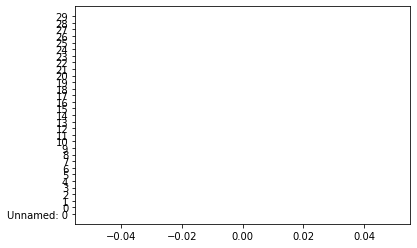

In [110]:
for col in data.columns:
    plt.plot(col)

In [97]:
# S = np array of prices without indexes

# input S, return log returns as numpy array without indexes starting with datapoint 2 as first element
def calc_return(S):
    S_old = np.delete(S,-1)
    S = np.delete(S,0)
    return np.log(S/S_old)
# output yearly volatility
# since each datapoint is 1/200 of a day, must convert to daily then yearly
#   daily = datapoint vol * sqrt(200)
#   yearly = daily * sqrt(252)a

# simple average datapoint std for first 199 datapoints
# INPUT: log returns
def calc_first_day_std(S):
    return (1/len(S)*((S**2).sum()))**0.5

# input old value for EMA, new datapoint,
# only keep 1 day worth of data so number datapoints = 200
# calculate simple average volatility for first 199 datapoints, then use that as the old_EMA for the 200th datapoint
def update_EMA(old_EMA, new_data):
    return new_data * (2/(200)) + old_EMA * (1-(2/(200)))

# for each new datapoint update datapoint std using exponential moving average
def update_std(old_std,new_ret):
    old_avg = old_std**2
    new_data = new_ret**2
    return (update_EMA(old_avg,new_data))**0.5

def historical_std(S):
    S = calc_return(S)
    old_std = calc_first_day_std(S[:200])
    for i in range(200,len(S)):
        old_std = update_std(old_std,S[i])
    return old_std

In [106]:
total_std = 0
for i in range(len(data.columns)-1):
    S = data[str(i)].values
    total_std += historical_std(S)
combined_std = total_std/(len(data.columns)-1)
daily_vol = combined_std * (200)**0.5
annual_vol = daily_vol * (252)**0.5


In [104]:
from dataclasses import astuple
from datetime import datetime
from utc_bot import UTCBot, start_bot
import proto.utc_bot as pb
import betterproto

import asyncio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import norm

# Setting available strike prices
option_strikes = [90, 95, 100, 105, 110]

class Case2ExampleBot(UTCBot):
    """
    An example bot for Case 2 of the 2021 UChicago Trading Competition. We recommend that you start
    by reading through this bot and understanding how it works. Then, make a copy of this file and
    start trying to write your own bot!
    """

    async def handle_round_started(self):
        """
        This function is called when the round is started. You should do your setup here, and
        start any tasks that should be running for the rest of the round.
        """
        # play around with these parameters:
        self.edge_buy = 10
        self.edge_sell = 10
        self.buy_option_q = 1
        self.sell_option_q = 1
        self.increment = 0.5

        # This variable will be a map from asset names to positions. We start out by initializing it
        # to zero for every asset.
        self.positions = {}
        self.order_ids = {}
        self.asset_names = []

        # For storing market orders
        self.positions["UC"] = 0

        # For storing options limit orders
        for strike in option_strikes:
            for flag in ["C", "P"]:
                asset_name = f"UC{strike}{flag}"
                self.asset_names.append(asset_name)
                self.positions[asset_name] = 0
                # id for bid, ask
                self.order_ids[asset_name] = ["",""]

        # Stores the current day (starting from 0 and ending at 5). This is a floating point number,
        # meaning that it includes information about partial days
        self.current_day = 0
        self.time_to_expiry = (26-self.current_day) / 252

        # Stores the current value of the underlying asset
        self.previous_price = 100
        self.underlying_price = 100
        self.old_vol = 0.0008269438519741517

        # Store risk measures
        self.risks = {"d": 0, "g": 0, "t":0, "v":0}
    
    async def place_ioc_orders(self):
        requests = []
        requests.append(
            self.place_order(
                "UC",
                pb.OrderSpecType.IOC,
                pb.OrderSpecSide.ASK,
                20,
                130
            )
        )
        
        requests.append(
            self.place_order(
                "UC",
                pb.OrderSpecType.IOC,
                pb.OrderSpecSide.BID,
                20,
                90
            )
        )
        responses = await asyncio.gather(*requests)
        for resp in responses:
            assert resp.ok
        
    def update_EMA(self,old_EMA, new_data):
        return new_data * (2/(200)) + old_EMA * (1-(2/(200)))

    def update_std(self,old_std,new_ret):
        old_avg = old_std**2
        new_data = new_ret**2
        return (self.update_EMA(old_avg,new_data))**0.5

    def compute_vol_estimate(self) -> float:
        """
        This function is used to provide an estimate of underlying's volatility. Because this is
        an example bot, we just use a placeholder value here. We recommend that you look into
        different ways of finding what the true volatility of the underlying is.
        """
        new_vol = self.update_std(self.old_vol,np.log(self.underlying_price/self.previous_price))
        self.old_vol = new_vol
        annual_vol = (new_vol * (200)**0.5) * (252)**0.5
        return annual_vol
    
    # Black Scholes
    
    def d1(self,S,K,T,r,sigma):
        return(np.log(S/K)+(r+sigma**2/2.)*T)/(sigma*np.sqrt(T))

    def d2(self,S,K,T,r,sigma):
        return self.d1(S,K,T,r,sigma)-sigma*np.sqrt(T)

    def bs_call(self,S,K,T,r,sigma):
        return S*norm.cdf(self.d1(S,K,T,r,sigma))-K*np.exp(-r*T)*norm.cdf(self.d2(S,K,T,r,sigma))

    def bs_put(self,S,K,T,r,sigma):
        return K*np.exp(-r*T)-S+self.bs_call(S,K,T,r,sigma)

    # Implied Volatility:

    def iv_call(self,S,K,T,r,C):
        return max(0, fsolve((lambda sigma: np.abs(self.bs_call(S,K,T,r,sigma) - C)), [1])[0])
                        
    def iv_put(self,S,K,T,r,P):
        return max(0, fsolve((lambda sigma: np.abs(self.bs_put(S,K,T,r,sigma) - P)), [1])[0])
    
    # Greeks

    def delta_call(self,S,K,T,C):
        sigma = self.iv_call(S,K,T,0,C)
        return 100 * norm.cdf(self.d1(S,K,T,0,sigma))

    def gamma_call(self,S,K,T,C):
        sigma = self.iv_call(S,K,T,0,C)
        return 100 * norm.pdf(self.d1(S,K,T,0,sigma))/(S * sigma * np.sqrt(T))

    def vega_call(self,S,K,T,C):
        sigma = self.iv_call(S,K,T,0,C)
        return 100 * norm.pdf(self.d1(S,K,T,0,sigma)) * S * np.sqrt(T)

    def theta_call(self,S,K,T,C):
        sigma = self.iv_call(S,K,T,0,C)
        return 100 * S * norm.pdf(self.d1(S,K,T,0,sigma)) * sigma/(2 * np.sqrt(T))

    def delta_put(self,S,K,T,C):
        sigma = self.iv_put(S,K,T,0,C)
        return 100 * (norm.cdf(self.d1(S,K,T,0,sigma)) - 1)

    def gamma_put(self,S,K,T,C):
        sigma = self.iv_put(S,K,T,0,C)
        return 100 * norm.pdf(self.d1(S,K,T,0,sigma))/(S * sigma * np.sqrt(T))

    def vega_put(self,S,K,T,C):
        sigma = self.iv_put(S,K,T,0,C)
        return 100 * norm.pdf(self.d1(S,K,T,0,sigma)) * S * np.sqrt(T)

    def theta_put(self,S,K,T,C):
        sigma = self.iv_put(S,K,T,0,C)
        return 100 * S * norm.pdf(self.d1(S,K,T,0,sigma)) * sigma/(2 * np.sqrt(T))

    def check_valid_trade(self, tag,S,K,T,C):
        if tag == "C":
            d = self.delta_call(S,K,T,C)
            g = self.gamma_call(S,K,T,C)
            t = self.theta_call(S,K,T,C)
            v = self.vega_call(S,K,T,C)
        else:
            d = self.delta_put(S,K,T,C)
            g = self.gamma_put(S,K,T,C)
            t = self.theta_put(S,K,T,C)
            v = self.vega_put(S,K,T,C)
        return [abs(d) < 2000 and abs(g) < 5000 and abs(t) < 1000000 and abs(v) < 500000, d, g, t, v]

    def check_cum_limits(self, d,g,t,v):
        d = self.risks["d"] + d
        g = self.risks["g"] + g
        t = self.risks["t"] + t
        v = self.risks["v"] + v
        return {"d":[abs(d) > 2000,d], "g":[abs(g) > 5000,g], "t":[abs(t) > 1000000,t], "v":[abs(v) > 500000,v]}

    def compute_options_price(
        self,
        flag: str,
        underlying_px: float,
        strike_px: float,
        time_to_expiry: float,
        volatility: float,
    ) -> float:
        """
        This function should compute the price of an option given the provided parameters. Some
        important questions you may want to think about are:
            - What are the units associated with each of these quantities?
            - What formula should you use to compute the price of the option?
            - Are there tricks you can use to do this more quickly?
        You may want to look into the py_vollib library, which is installed by default in your
        virtual environment.
        """
        if flag=="C":
            price = self.bs_call(underlying_px,strike_px,time_to_expiry,0,volatility)
        else:
            price = self.bs_put(underlying_px,strike_px,time_to_expiry,0,volatility)
        return price
    
    async def update_options_quotes(self):
        """
        This function will update the quotes that the bot has currently put into the market.

        In this example bot, the bot won't bother pulling old quotes, and will instead just set new
        quotes at the new theoretical price every time a price update happens. We don't recommend
        that you do this in the actual competition
        """
        vol = self.compute_vol_estimate()

        requests = []
        
        for strike in option_strikes:
            for flag in ["C", "P"]:
                asset_name = f"UC{strike}{flag}"
                theo = self.compute_options_price(
                    flag, self.underlying_price, strike, self.time_to_expiry, vol
                )
                if flag == "C":
                    iv_e = self.iv_call(self.underlying_price, strike, self.time_to_expiry, 0, self.edge)
                    iv_e_buy = iv_e
                    iv_e_sell = iv_e
                    res_buy = self.check_valid_trade(flag,self.underlying_price, strike, self.time_to_expiry, theo-iv_e_buy)
                    res_sell = self.check_valid_trade(flag,self.underlying_price, strike, self.time_to_expiry, theo+iv_e_sell)
                    while not res_buy[0]:
                        self.edge_buy += self.increment
                        iv_e_buy = self.iv_call(self.underlying_price, strike, self.time_to_expiry, 0, self.edge_buy)
                    while not res_sell[0]:
                        self.edge_sell += self.increment
                        iv_e_sell = self.iv_call(self.underlying_price, strike, self.time_to_expiry, 0, self.edge_sell)
                else:
                    iv_e = self.iv_put(self.underlying_price, strike, self.time_to_expiry, 0, self.edge)
                    iv_e_buy = iv_e
                    iv_e_sell = iv_e
                    res_buy = self.check_valid_trade(flag,self.underlying_price, strike, self.time_to_expiry, theo-iv_e_buy)
                    res_sell = self.check_valid_trade(flag,self.underlying_price, strike, self.time_to_expiry, theo+iv_e_sell)
                    while not res_buy[0]:
                        self.edge_buy += self.increment
                        iv_e_buy = self.iv_put(self.underlying_price, strike, self.time_to_expiry, 0, self.edge_buy)
                    while not res_sell[0]:
                        self.edge_sell += self.increment
                        iv_e_sell = self.iv_put(self.underlying_price, strike, self.time_to_expiry, 0, self.edge_sell)

                limits_results_buy = self.check_cum_limits(res_buy[1],res_buy[2],res_buy[3],res_buy[4])
                limits_results_sell = self.check_cum_limits(res_sell[1],res_sell[2],res_sell[3],res_sell[4])

                # If can't buy then sell
                if limits_results_buy["g"][0] or limits_results_buy["v"][0] or limits_results_buy["t"][0]:
                    # sell
                    requests.append(
                        self.modify_order(
                            self.order_ids[asset_name][1],
                            asset_name,
                            pb.OrderSpecType.LIMIT,
                            pb.OrderSpecSide.ASK,
                            self.sell_option_q,
                            theo + iv_e,
                        )
                    )
                
                # If can't sell then buy
                elif limits_results_sell["g"][0] or limits_results_sell["v"][0] or limits_results_sell["t"][0]:
                    # buy   
                    requests.append(
                        self.modify_order(
                            self.order_ids[asset_name][0],
                            asset_name,
                            pb.OrderSpecType.LIMIT,
                            pb.OrderSpecSide.BID,
                            self.buy_option_q,  # How should this quantity be chosen?
                            theo - iv_e,  # How should this price be chosen?
                        )
                    )
                # otherwise do both because it doesn't matter
                else:
                    requests.append(
                        self.modify_order(
                            self.order_ids[asset_name][0],
                            asset_name,
                            pb.OrderSpecType.LIMIT,
                            pb.OrderSpecSide.BID,
                            self.buy_option_q,  # How should this quantity be chosen?
                            theo - iv_e,  # How should this price be chosen?
                        )
                    )
                
                    requests.append(
                        self.modify_order(
                            self.order_ids[asset_name][1],
                            asset_name,
                            pb.OrderSpecType.LIMIT,
                            pb.OrderSpecSide.ASK,
                            self.sell_option_q,
                            theo + iv_e,
                        )
                    )

        # optimization trick -- use asyncio.gather to send a group of requests at the same time
        # instead of sending them one-by-one
        responses = await asyncio.gather(*requests)
        for i in range(0,len(responses),2):
            if not responses[i].ok:
                print(responses[i].message)
            if not responses[i+1].ok:
                print(responses[i+1].message)
            resp_call = responses[i]
            resp_put = responses[i+1]
            self.order_ids[self.asset_names[i]] = resp_call.order_id
            self.order_ids[self.asset_names[i+1]] = resp_put.order_id

    async def handle_exchange_update(self, update: pb.FeedMessage):

        kind, _ = betterproto.which_one_of(update, "msg")

        if kind == "pnl_msg":
            # When you hear from the exchange about your PnL, print it out
            print("My PnL:", update.pnl_msg.m2m_pnl)

        elif kind == "fill_msg":
            # When you hear about a fill you had, update your positions
            fill_msg = update.fill_msg

            if fill_msg.order_side == pb.FillMessageSide.BUY:
                self.positions[fill_msg.asset] += update.fill_msg.filled_qty
                if len(fill_msg.asset)>2:
                    res = self.check_valid_trade(fill_msg.asset[-1],self.underlying_price, int(fill_msg.asset[2:-1]), self.time_to_expiry, fill_msg.price)
                    self.risks["d"] += res[1]
                    self.risks["g"] += res[2]
                    self.risks["t"] += res[3]
                    self.risks["v"] += res[4]
                    if fill_msg.asset[-1]=="C":
                        # hedge delta by selling delta shares of stock
                        resp = self.place_order(
                            "UC",
                            pb.OrderSpecType.MARKET,
                            pb.OrderSpecSide.ASK,
                            self.risks["d"]
                        )
                    else:
                        # hedge delta by buying delta shares of stock
                        resp = self.place_order(
                            "UC",
                            pb.OrderSpecType.MARKET,
                            pb.OrderSpecSide.BID,
                            abs(self.risks["d"])
                        )
                else:
                    self.risks["d"] += update.fill_msg.filled_qty
            else:
                self.positions[fill_msg.asset] -= update.fill_msg.filled_qty
                if len(fill_msg.asset)>2:
                    # what to do when selling an option
                    pass
                else:
                    self.risks["d"] -= update.fill_msg.filled_qty
            

        elif kind == "market_snapshot_msg":
            # When we receive a snapshot of what's going on in the market, update our information
            # about the underlying price.
            book = update.market_snapshot_msg.books["UC"]
            print(book)
            # Compute the mid price of the market and store it
            self.previous_price = self.underlying_price
            self.underlying_price = (
                float(book.bids[0].px) + float(book.asks[0].px)
            ) / 2

            await self.update_options_quotes()

        elif (
            kind == "generic_msg"
            and update.generic_msg.event_type == pb.GenericMessageType.MESSAGE
        ):
            # The platform will regularly send out what day it currently is (starting from day 0 at
            # the start of the case) 
            self.current_day = float(update.generic_msg.message)
            self.time_to_expiry = (26-self.current_day) / 252
        # If a request to place an order fails, a message of this kind will be sent
        elif kind == "request_failed_msg":
            print("request failed :", update.request_failed_msg)
        elif kind == "trade_msg":
            pass
